In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/APP Deep Learn/petfinder-adoption-prediction.zip'
extraction_path = '/content/petfinder-data'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print(f"Successfully extracted '{zip_file_path}' to '{extraction_path}'")
print(f"Contents of '{extraction_path}':")
for item in os.listdir(extraction_path):
    print(f"- {item}")

Successfully extracted '/content/drive/MyDrive/APP Deep Learn/petfinder-adoption-prediction.zip' to '/content/petfinder-data'
Contents of '/content/petfinder-data':
- BreedLabels.csv
- train
- test
- train_images
- train_sentiment
- test_images
- breed_labels.csv
- PetFinder-BreedLabels.csv
- StateLabels.csv
- state_labels.csv
- PetFinder-ColorLabels.csv
- test_sentiment
- color_labels.csv
- PetFinder-StateLabels.csv
- train_metadata
- test_metadata
- ColorLabels.csv


In [ ]:
import pandas as pd

In [ ]:
train_csv_path = '/content/petfinder-data/train/train.csv'
train_csv_data = pd.read_csv(train_csv_path)
print(train_csv_data)

       Type            Name  Age  Breed1  Breed2  Gender  Color1  Color2  \
0         2          Nibble    3     299       0       1       1       7   
1         2     No Name Yet    1     265       0       1       1       2   
2         1          Brisco    1     307       0       1       2       7   
3         1            Miko    4     307       0       2       1       2   
4         1          Hunter    1     307       0       1       1       0   
...     ...             ...  ...     ...     ...     ...     ...     ...   
14988     2             NaN    2     266       0       3       1       0   
14989     2  Serato & Eddie   60     265     264       3       1       4   
14990     2         Monkies    2     265     266       3       5       6   
14991     2         Ms Daym    9     266       0       2       4       7   
14992     1            Fili    1     307     307       1       2       0   

       Color3  MaturitySize  ...  Health  Quantity  Fee  State  \
0           0        

In [ ]:
%%bash
mkdir -p ImageData

## Task
Collect all image file paths from the 'train_images' directory within the `/content/petfinder-data` folder, map these paths to their corresponding 'PetID's, and then integrate this mapping into the `train_csv_data` DataFrame as a new column.

### List image files

### Subtask:
Collect all image file paths from the 'train_images' directory, ensuring they are correctly linked to their respective 'PetID's.


In [ ]:
train_images_path = os.path.join(extraction_path, 'train_images')
train_image_files = []

for filename in os.listdir(train_images_path):
    if filename.endswith(('.jpg', '.jpeg')):
        # PetID is the part of the filename before the first hyphen
        pet_id = filename.split('-')[0]
        full_path = os.path.join(train_images_path, filename)
        train_image_files.append({'PetID': pet_id, 'Path': full_path})

print(f"Found {len(train_image_files)} training image files.")
# Display the first 5 entries to verify
print("First 5 entries of train_image_files:")
for i in range(min(5, len(train_image_files))):
    print(train_image_files[i])

Found 58311 training image files.
First 5 entries of train_image_files:
{'PetID': '2418f7929', 'Path': '/content/petfinder-data/train_images/2418f7929-5.jpg'}
{'PetID': '36b57b1ee', 'Path': '/content/petfinder-data/train_images/36b57b1ee-3.jpg'}
{'PetID': '9c76163ca', 'Path': '/content/petfinder-data/train_images/9c76163ca-1.jpg'}
{'PetID': '10741c443', 'Path': '/content/petfinder-data/train_images/10741c443-1.jpg'}
{'PetID': 'e3b39a9f5', 'Path': '/content/petfinder-data/train_images/e3b39a9f5-2.jpg'}


In [ ]:
image_paths_df = pd.DataFrame(train_image_files)

# Merge train_csv_data with image_paths_df on PetID
# This will create multiple rows for pets with multiple images
merged_data_with_image_paths = pd.merge(
    train_csv_data[['PetID', 'AdoptionSpeed']],
    image_paths_df,
    on='PetID',
    how='inner' # Use inner merge to only include pets that have images
)

# Select the desired columns: PetID, photo path (Path), and AdoptionSpeed
final_df = merged_data_with_image_paths[['PetID', 'Path', 'AdoptionSpeed']]

print("Expected DataFrame head:")
display(final_df)

Expected DataFrame head:


,PetID,Path,AdoptionSpeed
0,86e1089a3,/content/petfinder-data/train_images/86e1089a3...,2
1,6296e909a,/content/petfinder-data/train_images/6296e909a...,0
2,6296e909a,/content/petfinder-data/train_images/6296e909a...,0
3,3422e4906,/content/petfinder-data/train_images/3422e4906...,3
4,3422e4906,/content/petfinder-data/train_images/3422e4906...,3
...,...,...,...
58306,d981b6395,/content/petfinder-data/train_images/d981b6395...,3
58307,e4da1c9e4,/content/petfinder-data/train_images/e4da1c9e4...,4
58308,e4da1c9e4,/content/petfinder-data/train_images/e4da1c9e4...,4
58309,e4da1c9e4,/content/petfinder-data/train_images/e4da1c9e4...,4


In [ ]:
# Get the unique values of AdoptionSpeed to define the range of classes
# Assuming AdoptionSpeed values are 0-4 as per common PetFinder datasets,
# but dynamically determining it is safer.
adoption_speed_classes = sorted(final_df['AdoptionSpeed'].unique())
num_classes = len(adoption_speed_classes)

print(f"AdoptionSpeed classes found: {adoption_speed_classes}")

# Perform one-hot encoding on 'AdoptionSpeed' with dtype=int for 0s and 1s
one_hot_encoded = pd.get_dummies(final_df['AdoptionSpeed'], prefix='AdoptionSpeed', dtype=int)

# Convert the one-hot encoded DataFrame into a list of lists (vectors)
final_df['AdoptionSpeed_Vector'] = one_hot_encoded.values.tolist()

# Display the DataFrame with the new vector column
print("\nDataFrame with one-hot encoded AdoptionSpeed vector:")
display(final_df.head())

# Calculate the amount of each class
class_counts = final_df['AdoptionSpeed'].value_counts().sort_index()
print("\nAmount of each AdoptionSpeed class:")
print(class_counts)

AdoptionSpeed classes found: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

DataFrame with one-hot encoded AdoptionSpeed vector:


/tmp/ipython-input-2172998200.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['AdoptionSpeed_Vector'] = one_hot_encoded.values.tolist()


,PetID,Path,AdoptionSpeed,AdoptionSpeed_Vector
0,86e1089a3,/content/petfinder-data/train_images/86e1089a3...,2,"[0, 0, 1, 0, 0]"
1,6296e909a,/content/petfinder-data/train_images/6296e909a...,0,"[1, 0, 0, 0, 0]"
2,6296e909a,/content/petfinder-data/train_images/6296e909a...,0,"[1, 0, 0, 0, 0]"
3,3422e4906,/content/petfinder-data/train_images/3422e4906...,3,"[0, 0, 0, 1, 0]"
4,3422e4906,/content/petfinder-data/train_images/3422e4906...,3,"[0, 0, 0, 1, 0]"



Amount of each AdoptionSpeed class:
AdoptionSpeed
0     1363
1    11517
2    16438
3    15059
4    13934
Name: count, dtype: int64


In [ ]:
output_csv_path = '/content/drive/MyDrive/APP Deep Learn/Preprocess Data/final_df_with_image_paths_and_vectors.csv'
final_df.to_csv(output_csv_path, index=False)
print(f"DataFrame saved to {output_csv_path}")

DataFrame saved to /content/drive/MyDrive/APP Deep Learn/Preprocess Data/final_df_with_image_paths_and_vectors.csv


## Model

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/APP Deep Learn/Preprocess Data/final_df_with_image_paths_and_vectors.csv')
dataset.head()

,PetID,Path,AdoptionSpeed,AdoptionSpeed_Vector
0,86e1089a3,/content/petfinder-data/train_images/86e1089a3...,2,"[0, 0, 1, 0, 0]"
1,6296e909a,/content/petfinder-data/train_images/6296e909a...,0,"[1, 0, 0, 0, 0]"
2,6296e909a,/content/petfinder-data/train_images/6296e909a...,0,"[1, 0, 0, 0, 0]"
3,3422e4906,/content/petfinder-data/train_images/3422e4906...,3,"[0, 0, 0, 1, 0]"
4,3422e4906,/content/petfinder-data/train_images/3422e4906...,3,"[0, 0, 0, 1, 0]"


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'Path' and 'AdoptionSpeed_Vector' are features and target respectively
X = dataset[['Path']]
y = dataset['AdoptionSpeed_Vector']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (46648, 1)
X_test shape: (11663, 1)
y_train shape: (46648,)
y_test shape: (11663,)


In [ ]:
y_train.unique()

array(['[0, 0, 0, 0, 1]', '[0, 0, 0, 1, 0]', '[0, 0, 1, 0, 0]',
       '[0, 1, 0, 0, 0]', '[1, 0, 0, 0, 0]'], dtype=object)

In [ ]:
print(y_train.iloc[0])

[0, 0, 0, 0, 1]


#### ResNet 50
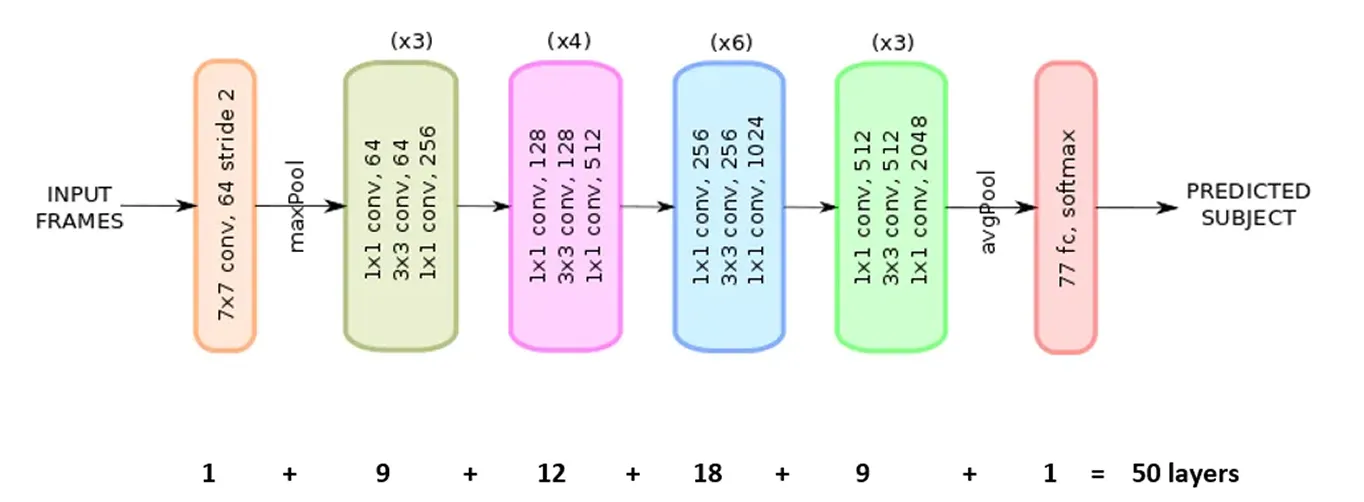

**Reasoning**:
I need to define the `PetFinderDataset` class as per the instructions. This involves importing `Dataset` and `Image`, and implementing `__init__`, `__len__`, and `__getitem__` methods.



In [ ]:
from torch.utils.data import Dataset
from PIL import Image

class PetFinderDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths.reset_index(drop=True) # Reset index to ensure alignment
        self.labels = labels.reset_index(drop=True) # Reset index to ensure alignment
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths.loc[idx, 'Path']
        image = Image.open(img_path).convert('RGB')
        label = torch.tensor(self.labels.loc[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

print("PetFinderDataset class defined.")

PetFinderDataset class defined.


## Update DataLoaders

### Subtask:
Modify the DataLoader creation to use the custom `PetFinderDataset` for both training and testing datasets.


In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Define BATCH_SIZE
BATCH_SIZE = 32  # You can adjust this value as needed

# Data Transforms & Augmentation (re-included for scope)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Create instances of PetFinderDataset
train_dataset = PetFinderDataset(X_train, y_train, transform=data_transforms['train'])
val_dataset = PetFinderDataset(X_test, y_test, transform=data_transforms['val'])

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Dynamically set NUM_CLASSES based on the length of the one-hot encoded label vectors
# Assuming y_train contains one-hot encoded vectors, take the length of the first one.
NUM_CLASSES = 5

print(f"Training dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Number of classes (dynamically set): {NUM_CLASSES}")

Training dataset size: 46648
Validation dataset size: 11663
Number of classes (dynamically set): 5


## Model Setup

### Subtask:
Load a pre-trained ResNet50 model, freeze its weights, and modify the final classification layer for `NUM_CLASSES`.


**Reasoning**:
I need to load a pre-trained ResNet50 model, freeze its weights, modify the final classification layer, and move the model to the appropriate device (GPU/CPU) as per the instructions.



In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# 2. Load a pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# 3. Freeze the weights of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# 4. Get the number of input features for the final fully connected layer
num_ftrs = model.fc.in_features

# 5. Replace the original fully connected layer with a new nn.Linear layer
model.fc = nn.Linear(num_ftrs, NUM_CLASSES)

# 6. Check for CUDA and move the model to the appropriate device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded and moved to {device}")
print(f"Final classification layer: {model.fc}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s]


Model loaded and moved to cuda:0
Final classification layer: Linear(in_features=2048, out_features=5, bias=True)


**Reasoning**:
I need to define the loss function and optimizer for training the model. The task specifies setting up the ResNet50 model, which was completed in the previous step. Now I'll proceed with the loss function and optimizer setup.



In [ ]:
import torch.optim as optim

# Define the loss function
# Since the labels are one-hot encoded, Binary Cross-Entropy with Logits is suitable for multi-label classification.
# If it's multi-class single-label, CrossEntropyLoss is generally used, but with one-hot targets, BCEWithLogitsLoss works.
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# We are only optimizing the parameters of the last layer (model.fc) because the other layers are frozen.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("Loss function and optimizer defined.")

Loss function and optimizer defined.


**Reasoning**:
I need to implement the training function that will iterate over the dataloaders for a specified number of epochs, calculate the loss, perform backpropagation, and update the model's weights. The main task specifies running the training loop for 5 epochs.



In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import ast # Import the ast module

class PetFinderDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths.reset_index(drop=True) # Reset index to ensure alignment
        self.labels = labels.reset_index(drop=True) # Reset index to ensure alignment
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths.loc[idx, 'Path']
        image = Image.open(img_path).convert('RGB')

        label_raw = self.labels.loc[idx]
        if isinstance(label_raw, str):
            label_list = ast.literal_eval(label_raw) # Convert string representation of list to actual list
        else:
            label_list = label_raw

        label = torch.tensor(label_list, dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, label

print("PetFinderDataset class defined and modified to handle string labels.")

PetFinderDataset class defined and modified to handle string labels.


**Reasoning**:
The `PetFinderDataset` class has been redefined to correctly handle the string representation of labels. Now, I need to re-instantiate the `DataLoader` objects and then call the `train_model` function to execute the training loop with the corrected dataset handling.



In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Define BATCH_SIZE
BATCH_SIZE = 32  # You can adjust this value as needed

# Data Transforms & Augmentation (re-included for scope)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Create instances of PetFinderDataset with the corrected class
train_dataset = PetFinderDataset(X_train, y_train, transform=data_transforms['train'])
val_dataset = PetFinderDataset(X_test, y_test, transform=data_transforms['val'])

# Create DataLoader instances
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

# Dynamically set NUM_CLASSES based on the length of the one-hot encoded label vectors
# Assuming y_train contains one-hot encoded vectors, take the length of the first one.
NUM_CLASSES = 5

print(f"Training dataset size: {dataset_sizes['train']}")
print(f"Validation dataset size: {dataset_sizes['val']}")
print(f"Number of classes (dynamically set): {NUM_CLASSES}")


# Define the training function (copied from previous step to ensure full execution)
import time
import copy

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Run the training loop
print("Starting model training...")
model = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, device, num_epochs=5)
print("Model training finished.")


Training dataset size: 46648
Validation dataset size: 11663
Number of classes (dynamically set): 5
Starting model training...
Epoch 0/4
----------
train Loss: 0.4670
val Loss: 0.4602

Epoch 1/4
----------
train Loss: 0.4628
val Loss: 0.4599

Epoch 2/4
----------
train Loss: 0.4607
val Loss: 0.4816

Epoch 3/4
----------
train Loss: 0.4595
val Loss: 0.4647

Epoch 4/4
----------
train Loss: 0.4596
val Loss: 0.4617

Training complete in 34m 41s
Best val Loss: 0.459943
Model training finished.


In [ ]:
# 1. Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# 2. Use a much smaller learning rate for fine-tuning
FINE_TUNE_LR = 1e-5

# 3. Re-configure optimizer to include all parameters
optimizer_ft = optim.Adam(model.parameters(), lr=FINE_TUNE_LR)

# 4. Train for a few more epochs
print("Starting Fine-tuning...")
model = train_model(model, criterion, optimizer_ft, dataloaders, dataset_sizes, device, num_epochs=3)

Starting Fine-tuning...
Epoch 0/2
----------
train Loss: 0.4441
val Loss: 0.4412

Epoch 1/2
----------
train Loss: 0.4294
val Loss: 0.4381

Epoch 2/2
----------
train Loss: 0.4130
val Loss: 0.4374

Training complete in 36m 48s
Best val Loss: 0.437428


In [ ]:
from sklearn.metrics import cohen_kappa_score

def evaluate_kappa(model, dataloader):
    model.eval() # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad(): # Disable gradient calculation during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            # Get predicted class index (assuming single-label multi-class classification)
            _, preds = torch.max(outputs, 1)

            # Convert one-hot encoded labels to single class index
            true_labels = torch.argmax(labels, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    kappa = cohen_kappa_score(all_labels, all_preds)
    return kappa

# Evaluate Kappa on the validation set
kappa_score = evaluate_kappa(model, dataloaders['val'])
print(f"Kappa Score on the validation set: {kappa_score:.4f}")

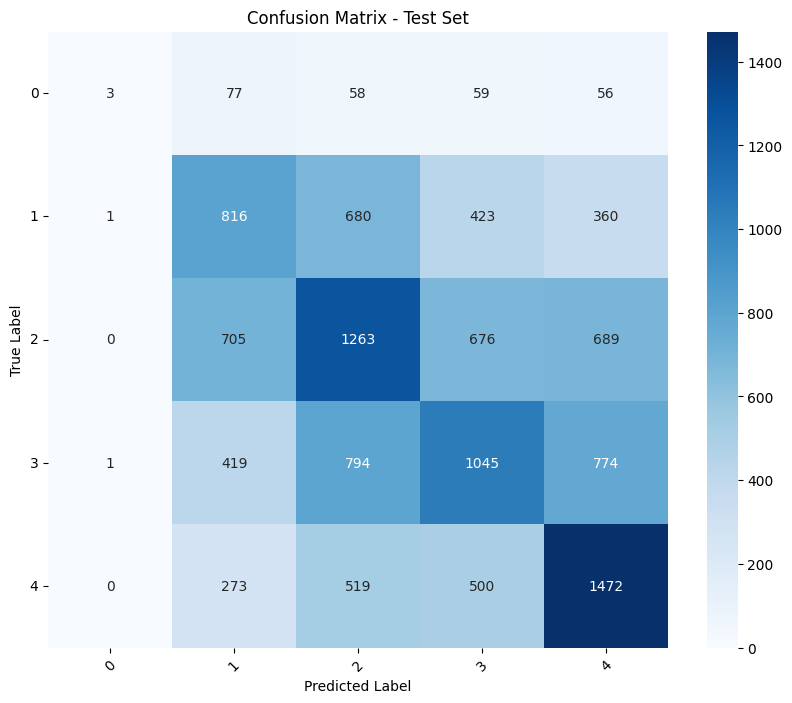

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    # Ensure DEVICE is defined if not already (from model setup)
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            # For BCEWithLogitsLoss, outputs are logits, so we apply sigmoid and then threshold
            # or directly get the max for single-label classification with one-hot targets
            # If it's multi-class, single-label, then torch.argmax(outputs, dim=1) is appropriate
            # Here, since it's one-hot encoded and we are trying to predict a single class,
            # torch.argmax is more suitable for getting a single predicted class index.
            _, preds = torch.max(outputs, 1)

            # Assuming labels are one-hot encoded for multi-class classification
            # Convert one-hot labels to single class index for confusion matrix
            true_labels = torch.argmax(labels, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Define class_names based on NUM_CLASSES
class_names = [str(i) for i in range(NUM_CLASSES)]

# Generate the plot using the test dataloader
plot_confusion_matrix(model, dataloaders['val'], class_names)

In [ ]:
import torch

# Save the model state dictionary
model_save_path = 'pet_pred_resnet50.pth'
torch.save(model.state_dict(), model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to pet_pred_resnet50.pth
